In [1]:
import random
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import torch
from matplotlib import pyplot as plt
import os
import unet_vnc
import random
from pathlib import Path
from scipy import ndimage
from torch.utils.data import DataLoader
import tkinter as tk
import pydicom

import torchvision.transforms as transforms
import torch
import unet3D_vnc
import utils_unet_vnc


In [2]:

random.seed(42) # ensure reproducible training/validation split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# directories with data and stored training checkpoints
# directory with data
DATA_DIR = Path.cwd()/'Data_for_model'
# Set the best epoch? by default set the last one (but revise later in tensorlog to see if there's overffiting)
BEST_EPOCH = 49
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights" / f"u_net_{BEST_EPOCH}.pth"

# Hyperparameters
NO_VALIDATION_SCANS = 2
IMAGE_SIZE = [64, 64]

# Find VNC scans in training directory
# Data preparation
VNC_scans = [
    location
    for location in DATA_DIR.glob("*")
]
random.shuffle (VNC_scans)

# Split into training/validation dataset after shuffling
partition = {"train": VNC_scans[:-NO_VALIDATION_SCANS],
    "validation": VNC_scans[-NO_VALIDATION_SCANS:],}


# Load validation data
valid_dataset = utils_unet_vnc.VNCDataset(partition["validation"], IMAGE_SIZE)



In [3]:
# Set model, and loss function
unet_model = unet_vnc.UNet().to(device)

# Load the state dictionary of the trained model checkpoint of the best epoch
unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR)) 

# set evaluation mode indicating that no gradients have to be computed
unet_model.eval()
loss_function = utils_unet_vnc.DiceBCELoss()



# Evaluate validation loss
valid_loss = 0.0
dice_scores = []

for batch in DataLoader(valid_dataset, batch_size=1, shuffle = False): # evaluate for all images
    inputs, targets, VNCscan_names = batch
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = torch.sigmoid(unet_model(inputs)) #forward pass through Unet
    outputs = outputs.detach() # prevent gradient computation during loss calculation (saves memory and computation time)
    
    loss = loss_function(outputs.float(), targets.float())
    valid_loss += loss.item()

    predictions = torch.round(outputs)
    dice_score = utils_unet_vnc.dice_coefficient(predictions, targets)

    dice_scores.append(dice_score)

print("Mean Dice Score:", np.mean(dice_scores))
mean_validation_loss = valid_loss/ len(valid_dataset)


C:\Users\eencinas\AppData\Local\Temp\ipykernel_20464\550153343.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR))


Mean Dice Score: 0.9428378


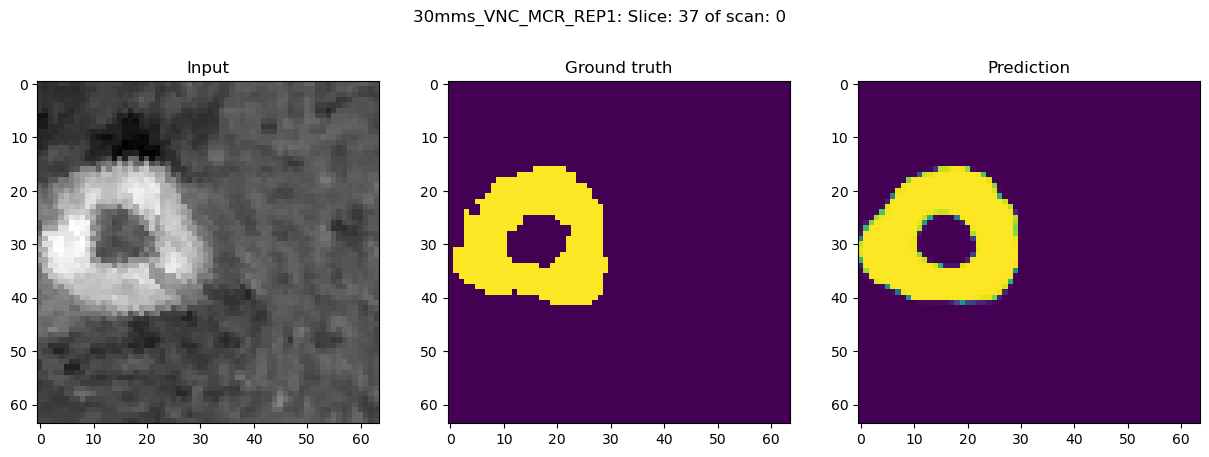

In [4]:

# output .mhd images with the predicted segmentations
with torch.no_grad():
    predict_index = 37 # here I just chose a random slice for testing
    # you should do this for all slices
    (input, target, this_VNCscan_name) = valid_dataset[predict_index]
    output = torch.sigmoid(unet_model(input[np.newaxis, ...])) #forward pass through Unet
    prediction = torch.round(output) # because dealing with birnay classfication tasks, where the output values represent prob
    slice_no = utils_unet_vnc.plot_results(input, target, output, predict_index, this_VNCscan_name)
    dice_score = utils_unet_vnc.dice_coefficient(prediction, target)
    ground_truth = target


In [8]:


# cropped_image_slice = get_mhdInput(DATA_DIR, VNCscan_name, slice_no)

# totalAS = utils_unet_vnc.AgatsonScore_calculation(cropped_image_slice, ground_truth[0])
# print(totalAS)
# totalAS_pred = AgatsonScore_calculation(cropped_image_slice, prediction[0,0])
# print(totalAS_pred)
IMAGE_SIZE = [64, 64]
totalAS_gt = utils_unet_vnc.AgatsonScore_calculation(target, DATA_DIR = Path.cwd()/'Data_for_model', VNCscan_name = this_VNCscan_name, slice_no=37, IMAGE_SIZE = [64, 64], pixel_size = 0.4296875)


TypeError: AgatsonScore_calculation() missing 1 required positional argument: 'calcium_mask'